# Project final # 
#### Akbar Ismatullayev 17376021, Jairoop Brar 19169291, Jaime Keith, Ian Yoon ###

In [1]:
library(tidyverse)
library(lubridate)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Reading the data for analysing

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

head(sessions)
head(players)

# quick sense-check on dimensions
dim(players)
dim(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 196   7

[1] 1535    5

## Introduction

#### About the data

The data this report will be analyzing comes from The Pacific Laboratory for Artificial Intelligence right here at UBC. They set up a minecraft server called PLAICraft and record play sessions with the goal of understanding how people play video games in order to advance artificial intelligence. They collected a set of data on the players on their server and are interested to know what kinds of players are the most likely to contribute more data so they can target them in their recruitment efforts. 


#### Data Description: ###


In [3]:
glimpse(players)
glimpse(sessions)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

player.csv contains demographic and information about each unique player. Each row represents one player, so there are 196 unique players.
What we also noticed that the formatting style of the column names are inconsistent, some are camelcase some are with an underscore.
For the variables:
* Experience is a character variable, with some classifactions like pro, veteran etc. It looks like an ordinal feature which means there is a orderning.
* subscribe is a boolean, saying if the player is subscribed to newsletter.
* hashed_email is a character variable which is unique for each player
* played_hours is a double variable, which says how many hours each player plays, however what we noticed is that there are players with zero play hours time, so they only created the account but no playing time, so we have to be carefull of that.
* name is a character variable, which is not unique and it is not usefull


session.csv contains records of all gameplay sessions for every player which can be connected through their 'hashed_email', also the variables as  their timestamps and duration which we can calculate. Each row corresponds to one gameplay session. Since there are 1535 rows which are more than the amount of playes, this suggest that there are duplicates of the hashed_email in the dataset so players are gaming more than once on their server. So we have to be carefull of that.
For the variables:
* hashed_email is a character variable which you can link to the player.
* start_time is a character variable saying when the session started.
* end_time is a character variable saying when the session ended.
* both orginal_start_time and orginal_end_time are the same or almost the same so I will remove them.

In order to target future players on how much data they are expected to contribute, we needed to analyze the player data set to see if any of these variables are able to predict how many hours someone will play on the server.


#### Summary statistics

In [4]:
summary(players)
summary(sessions)


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

 hashedEmail         start_time          end_time         original_start_time
 Length:1535        Length:1535        Length:1535        Min.   :1.712e+12  
 Class :character   Class :character   Class :character   1st Qu.:1.716e+12  
 Mode  :character   Mode  :character   Mode  :character   Median :1.719e+12  
                                                          Mean   :1.719e+12  
                                                          3rd Qu.:1.722e+12  
                                                          Max.   :1.727e+12  
                                                                             
 original_end_time  
 Min.   :1.712e+12  
 1st Qu.:1.716e+12  
 Median :1.719e+12  
 Mean   :1.719e+12  
 3rd Qu.:1.722e+12  
 Max.   :1.727e+12  
 NA's   :2          

Looking at the summary, we notice that there are empty columns in age (players) and orginal_end_time (session). Which we need to be carefull. For the subscribe variable we notice it is very skewed, most players are subscribed so this variable is very imbalanced

##### Potential issues in short #####
* age and orginal_end_time has na values
* experience can be made as an ordinal feature so beginner = 1, intermediate = 2, advanced = 3, pro = 4.
* some players dont have play time so they dont have any game session.
* both original_start_time and original_end_time are almost the same or the same
* subscribe is very imbalanced so there more true values than false values which can mislead a classification model.

#### Project Statement

The question this report is investigating is: 

*Can age predict experience level and/or the amount of hours played on the server and if so which specific age groups have the highest experience level and hour played?*

To answer this, the following variables do support the research question:

 * ##### Age — the main predictor variable.

 * ##### Experience — an ordinal outcome measure of player skill.

 * ##### Played_hours — a continuous measure representing total time spent playing.

Additional variables such as start_time, end_time, and duration_min from the sessions dataset can be used to validate play time records, although they are not essential for answering the primary question.

Variables including gender, subscribe and hashed_email do not contribute to the research question and are therefore excluded from further analysis.



## Methods & Results

### Minimal wrangling ####

Minimal cleaning was applied to ensure consistency across variable names and formats.
Column names were standardized and categorical variables were converted into factors to keep the ordening.

In [5]:
#make the format consistent
players <- players |>
  rename(
    hashed_email = hashedEmail,
    age = Age
  )

sessions <- sessions |>
  rename(
    hashed_email = hashedEmail
  )

# mutate the player dataset since experience, subscribe and gender are factor data's. But experience has an order so we make it as an ordinal feature

players <- players |>
    filter(!is.na(age)) |>
    mutate(
        experience = factor(experience, levels = c("Beginner", "Amateur","Regular","Veteran","Pro")),
        subscribe  = as.factor(subscribe),
        gender     = as.factor(gender),
        log_played_hours = log(played_hours+1)
  )

### Exploratory Data Analysis

##### Summary Statistics

In [6]:
players_means <- players |> 
                 summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE)))
players_means

played_hours,age,log_played_hours
<dbl>,<dbl>,<dbl>
5.904639,21.13918,0.5086921


This indicates that the typical player is around 21 years old and plays just under 6 hours, but we don't know yet if there are any outliers or how this data is distributed. To check for this, we have to plot the distribution of total played hours among players, specifically, the number of players that fall in each number of total hours played.

##### Checking the distribution of total play hours

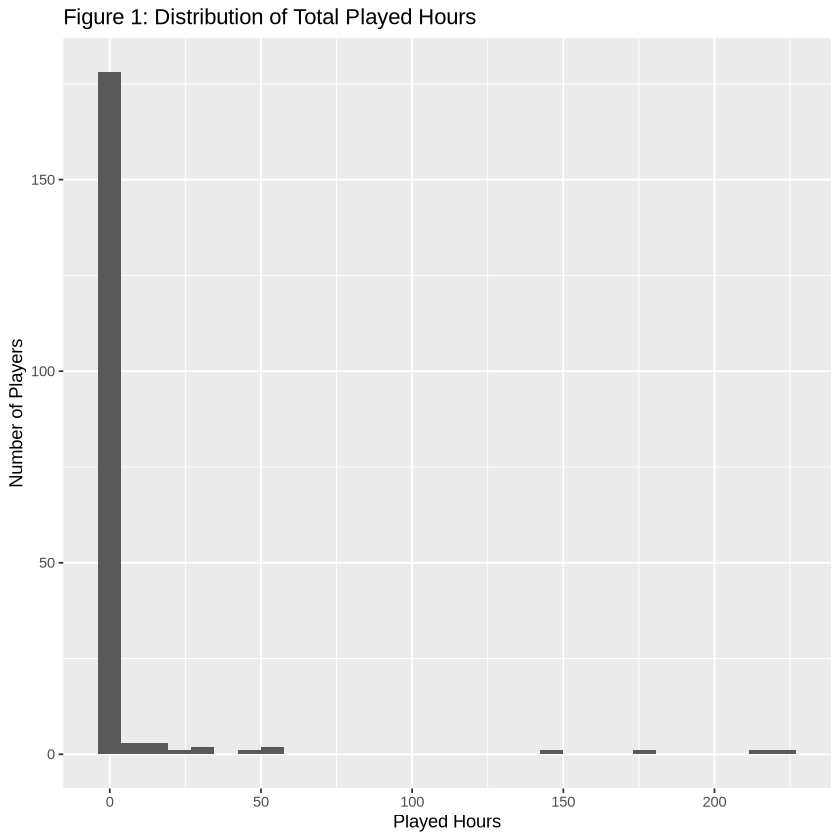

In [7]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(bins = 30) +
  labs(title = 'Figure 1: Distribution of Total Played Hours',
       x = "Played Hours", y = "Number of Players")

This confirms our initial thought, it shows the distribution of play hours is highly right skewed, suggesting most players have low engagement while a few play extensively. This supports the need to consider possible transformations like log for example in later analysis.

### Approach

#### Proposed Method

To investigate whether age predicts experience level and hours played, we considered the following approaches:

<!--Guys mabye we use knn, but the only issue there is, experience leevel is an orderning so an ordinal logistic regression is the most logicall even though we never had this in class -->
* Ordinal logistic regression for predicting experience level (ordered categories: Beginner -> Pro).

* Linear regression for predicting total hours played (log transformed to reduce skewness).

* KNN regression as an alternative non-parametric approach for both outcomes to see if local patterns differ from parametric models.

This approach allows us to compare parametric and non-parametric models and will show which captures the relationships most effectively

#### Why This Method Is Appropriate

* Ordinal logistic regression respects the natural order in experience levels, making it suitable for ordinal outcomes.

* linear regression is appropriate for continuous numeric outcomes like played hours, especially after log transformation to handle skewness.

* KNN regression is non-parametric so it makes no assumptions about the functional form between age and the outcomes.

#### Assumptions

##### General Assumptions About Our Data:
* We are assuming that data collected from the PLAICraft server is representative of the player base we will analyze, and that the sample of 196 players accurately reflects the entire population of interest.
* Each player and their respective data in the players.csv dataset is unique and independent of other players, and each player's age or experience level is not statistically dependent on any other player.
* All values within the dataset are recorded accurately, and excluding any NAs, the rest of the recorded data is accurate and not manipulated in any way.

##### Linear Regression Assumptions:
* We are assuming that there is a linear relationship between Age (the predictor) and played_hours (the outcome)
* assuming that any outliers or residuals are evenly distributed throughout the time_played data, and that doing a log transformation (as our data is right-skewed) will help highlight the normality of the data, and that the aforementioned residuals are distributed evenly across all age groups (one or a select few age groups don't have all of the residuals or outliers)

#####  Missing Data Values (and zeros) Assumptions:
* As previously mentioned, any NAs, specifically found in the Age of players can be excluded and removed from the data without any significant impact on the overall trends, as these NAs are sparse and shouldn't lead to any unfairness.
* We are assuming that players with played_hours of 0.0 are valid, as they likely joined the research but never played. By transforming the value in our linear regression through a log transformation (log(played_hours + 1)) , these values of 0.0 won't impact the data drastically.

### Linear Regression and K-NN Regression (Predicting Time Played)

Moving on, we used a linear regression and K-NN regression model to predict the total time played based on the player's age. Additionally, to account for the skew in Figure 1, we used the log-transformed `played_hours` which is `log_played_hours`. Calculated using `log(played_hours + 1)`.

In [8]:
players_split <- initial_split(players, prop = 0.75, strata = log_played_hours)   #im using log_played_hours instead of played_hours here to account for the 0.0 values!
players_train <- training(players_split)
players_test <- testing(players_split)

In [9]:
# Linear Regression!
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(log_played_hours ~ age, data = players_train)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_train)

lm_fit

lm_test_results <- lm_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = log_played_hours, estimate = .pred)

lm_test_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
   0.572993    -0.001717  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.93993206
rsq,standard,0.04207444
mae,standard,0.58166474


Here we see that the Linear Regression Model's calculated RMSPE is 1.2765!

In [10]:
# K-NN Regression!
knn_recipe <- recipe(log_played_hours ~ age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

knn_metrics <- predict(knn_fit, players_test) |>
    bind_cols(players_test) |>
    metrics(truth = log_played_hours, estimate = .pred)

knn_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.018997703
rsq,standard,0.001810642
mae,standard,0.516255086


Here we see that the K-NN Regression Model's calculated RMSPE is 1.3383!

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


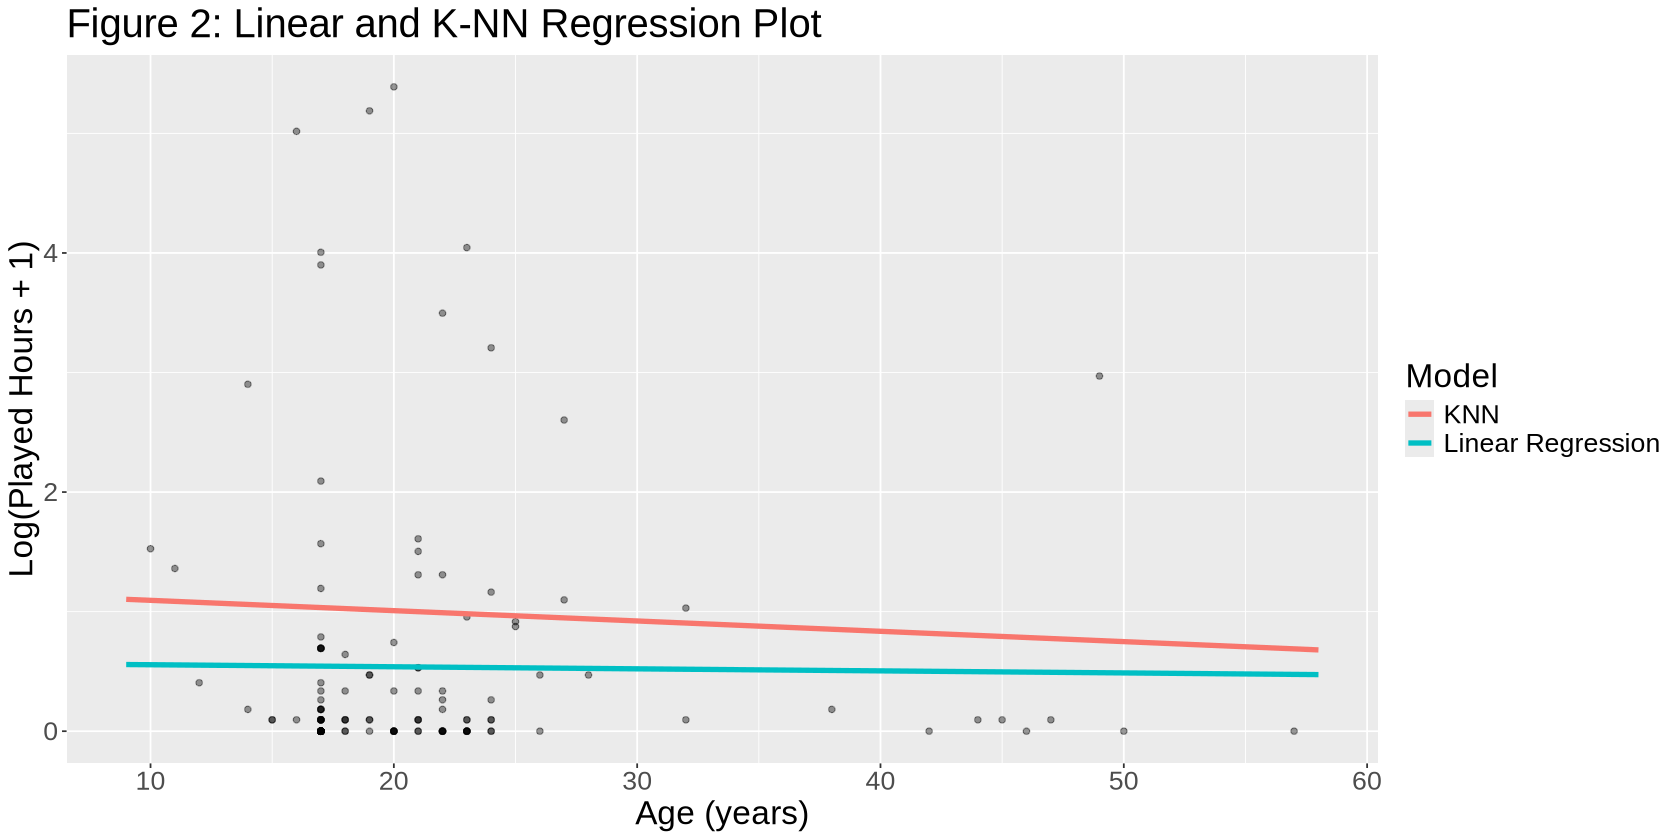

In [11]:
# Plotting Linear and K-NN Regression Models!
age_prediction_grid <- tibble(
    age = c(players |> select(age) |> min(), 
            players |> select(age) |> max() ) )

lm_preds <- lm_fit |>
    predict(age_prediction_grid) |>
    bind_cols(age_prediction_grid) |>
    mutate(Model = "Linear Regression")

knn_preds <- knn_fit |>
    predict(age_prediction_grid) |>
    bind_cols(age_prediction_grid)|>
    mutate(Model = "KNN")

options(repr.plot.width = 14, repr.plot.height = 7)
regression_plot <- bind_rows(knn_preds, lm_preds) |>
    ggplot(aes(x = age, y = .pred, color = Model)) +
    geom_point(data = players_train, aes(y = log_played_hours), alpha = 0.4, color = 'Black') +
    geom_line(size = 1.5) +
    labs(x = "Age (years)", y = "Log(Played Hours + 1)", title = "Figure 2: Linear and K-NN Regression Plot") +
    theme(text = element_text(size = 20))

regression_plot

## Discussion

table,variable,type,meaning
<chr>,<chr>,<chr>,<chr>
players,experience,factor,Experience tier
players,subscribe,logical,Has subscription
players,hashed_email,id,Unique player key
⋮,⋮,⋮,⋮
sessions,end_time,string,Session end (d/m/Y H:M)
sessions,original_start_time,numeric,Start epoch (ms)
sessions,original_end_time,numeric,End epoch (ms)


hashed_email,experience,subscribe,age,minutes,sessions
<chr>,<fct>,<fct>,<dbl>,<dbl>,<int>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,Pro,TRUE,9,2019,27
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,Veteran,TRUE,17,255,3
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,Veteran,FALSE,17,5,1
23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,Amateur,TRUE,21,50,1
7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,Regular,TRUE,21,9,1
f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,Amateur,TRUE,17,0,0


variable,n,mean,sd,min,p25,med,p75,max
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,194,21.1391753,7.389687,9,17,19.00000000,22.7500000,58.000000
log_played_hours,194,0.5086921,1.044871,0,0,0.09531018,0.4700036,5.412092
played_hours,194,5.9046392,28.497934,0,0,0.10000000,0.6000000,223.100000


n,mean,sd,min,p25,med,p75,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1533,50.85845,55.57357,3,9,30,73,259


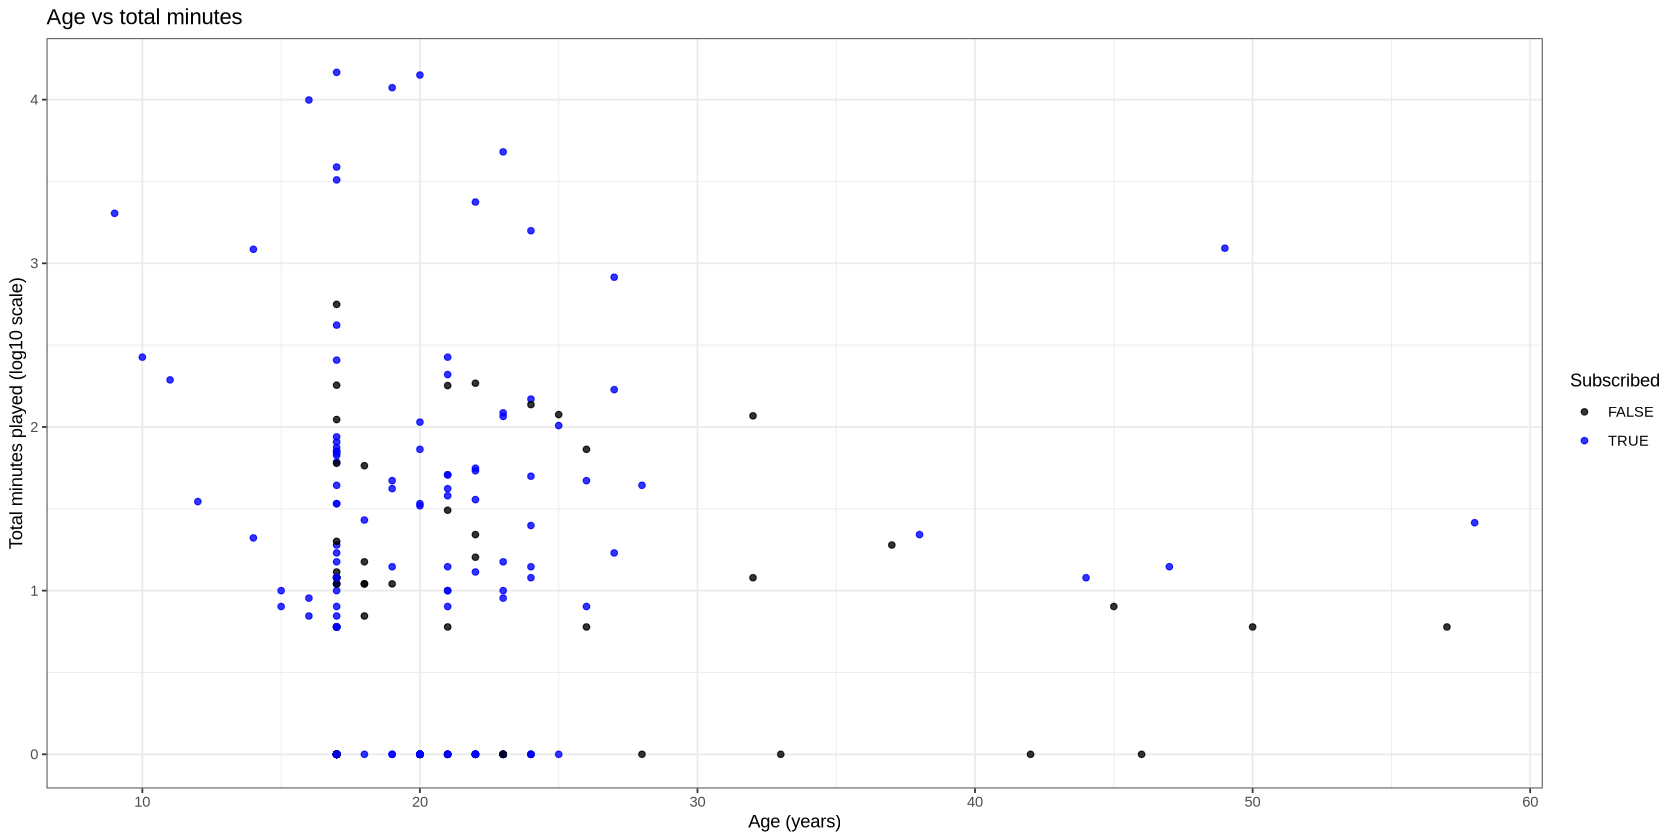

In [12]:
# variable dictionary (just to keep track of what's what) 

var_dict <- tibble(
  table    = c(rep("players", 7), rep("sessions", 5)),
  variable = c(
    "experience","subscribe","hashed_email","played_hours","name","gender","age",
    "hashed_email","start_time","end_time","original_start_time","original_end_time"
  ),
  type = c(
    "factor","logical","id","numeric","string","factor","numeric",
    "id","string","string","numeric","numeric"
  ),
  meaning = c(
    "Experience tier","Has subscription","Unique player key","Total lifetime hours",
    "Player name","Self-reported gender","Age in years",
    "Unique player key","Session start (d/m/Y H:M)","Session end (d/m/Y H:M)",
    "Start epoch (ms)","End epoch (ms)"
  )
)

var_dict

# convert session timestamps to usable datetimes --------------------------
# The start/end times are strings like "14/05/2024 19:22" so I parsed them
# Then computed the playtime length for each session in minutes

sessions <- sessions |>
  mutate(
    start_time = dmy_hm(start_time, tz = "UTC"),
    end_time   = dmy_hm(end_time,   tz = "UTC"),
    duration_min = as.numeric(difftime(end_time, start_time, units = "mins"))
  )

# summarise total playtime per player 
# For each hashed_email, we want:
# - total minutes played
# - average session length
# - number of sessions actually logged

by_player <- sessions |>
  group_by(hashed_email) |>
  summarise(
    minutes  = sum(duration_min, na.rm = TRUE),
    avg_min  = mean(duration_min, na.rm = TRUE),
    sessions = sum(!is.na(duration_min)),
    .groups = "drop"
  )

# join the playtime summary onto the players table 
# If a player has no sessions, I filled their minutes/avg/sessions with zero.

dat <- players |>
  left_join(by_player, by = "hashed_email") |>
  mutate(
    minutes  = replace_na(minutes,  0),
    avg_min  = replace_na(avg_min,  0),
    sessions = replace_na(sessions, 0)
  )

dat |>
  select(hashed_email, experience, subscribe, age, minutes, sessions) |>
  head()

# numeric summaries for the players table 
# A quick overview of the numeric columns (Age, played_hours, etc.)

players_num_summary <- players |>
  select(where(is.numeric)) |>
  pivot_longer(everything(), names_to = "variable", values_to = "value") |>
  group_by(variable) |>
  summarise(
    n    = sum(!is.na(value)),
    mean = mean(value, na.rm = TRUE),
    sd   = sd(value,   na.rm = TRUE),
    min  = min(value,  na.rm = TRUE),
    p25  = quantile(value, 0.25, na.rm = TRUE),
    med  = median(value,   na.rm = TRUE),
    p75  = quantile(value, 0.75, na.rm = TRUE),
    max  = max(value,  na.rm = TRUE),
    .groups = "drop"
  )

players_num_summary

# summary of session durations 
# Same type of summary but just for the session length variable.

duration_summary <- sessions |>
  summarise(
    n    = sum(!is.na(duration_min)),
    mean = mean(duration_min, na.rm = TRUE),
    sd   = sd(duration_min,   na.rm = TRUE),
    min  = min(duration_min,  na.rm = TRUE),
    p25  = quantile(duration_min, 0.25, na.rm = TRUE),
    med  = median(duration_min,   na.rm = TRUE),
    p75  = quantile(duration_min, 0.75, na.rm = TRUE),
    max  = max(duration_min,  na.rm = TRUE)
  )

duration_summary

# plot: age vs total minutes 
# We log-transform (minutes + 1) because playtime is extremely skewed,
# and we colour by subscription status just to see if subs behave differently.

dat |>
  ggplot(aes(x = age,
             y = log10(minutes + 1),
             colour = subscribe)) +
  geom_point(alpha = 0.8) +
  scale_colour_manual(
    values = c("FALSE" = "black", "TRUE" = "blue"),
    name = "Subscribed"
  ) +
  labs(
    x = "Age (years)",
    y = "Total minutes played (log10 scale)",
    title = "Age vs total minutes"
  ) +
  theme_bw()


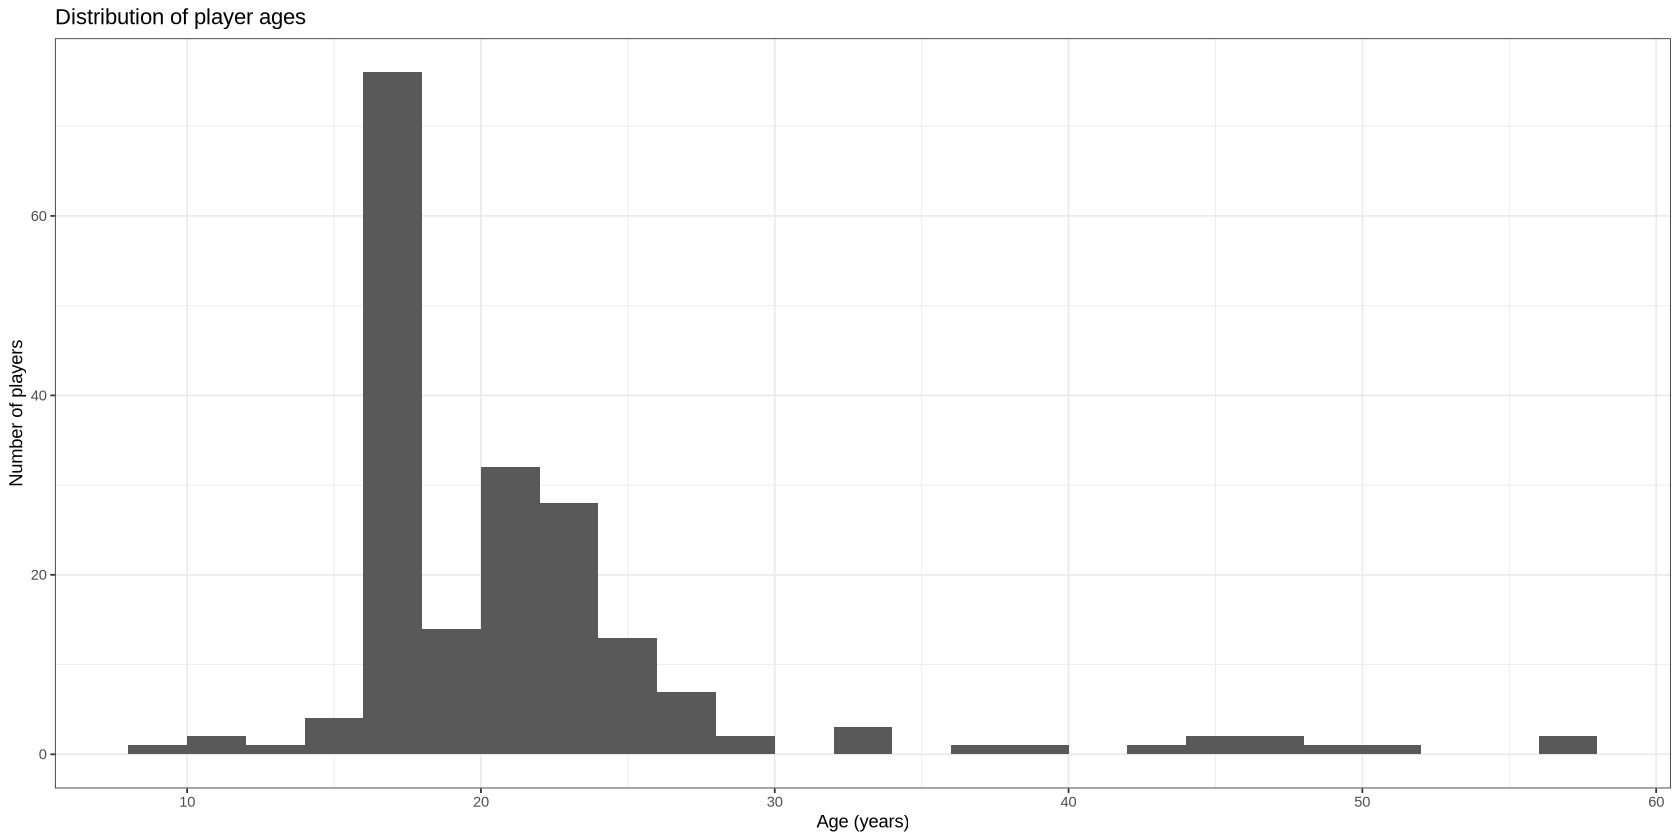

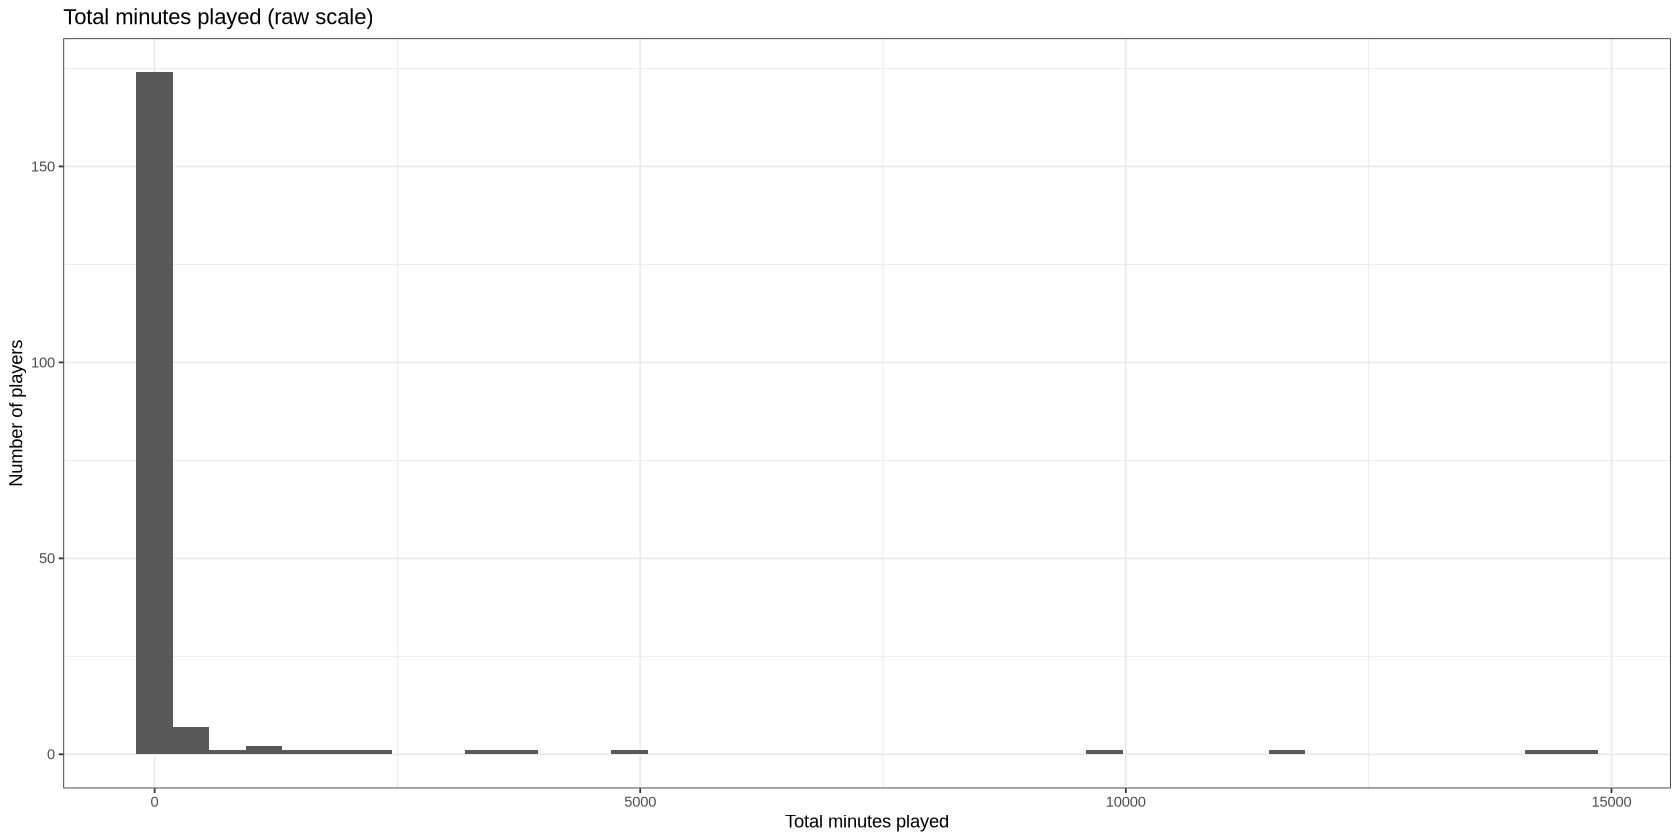

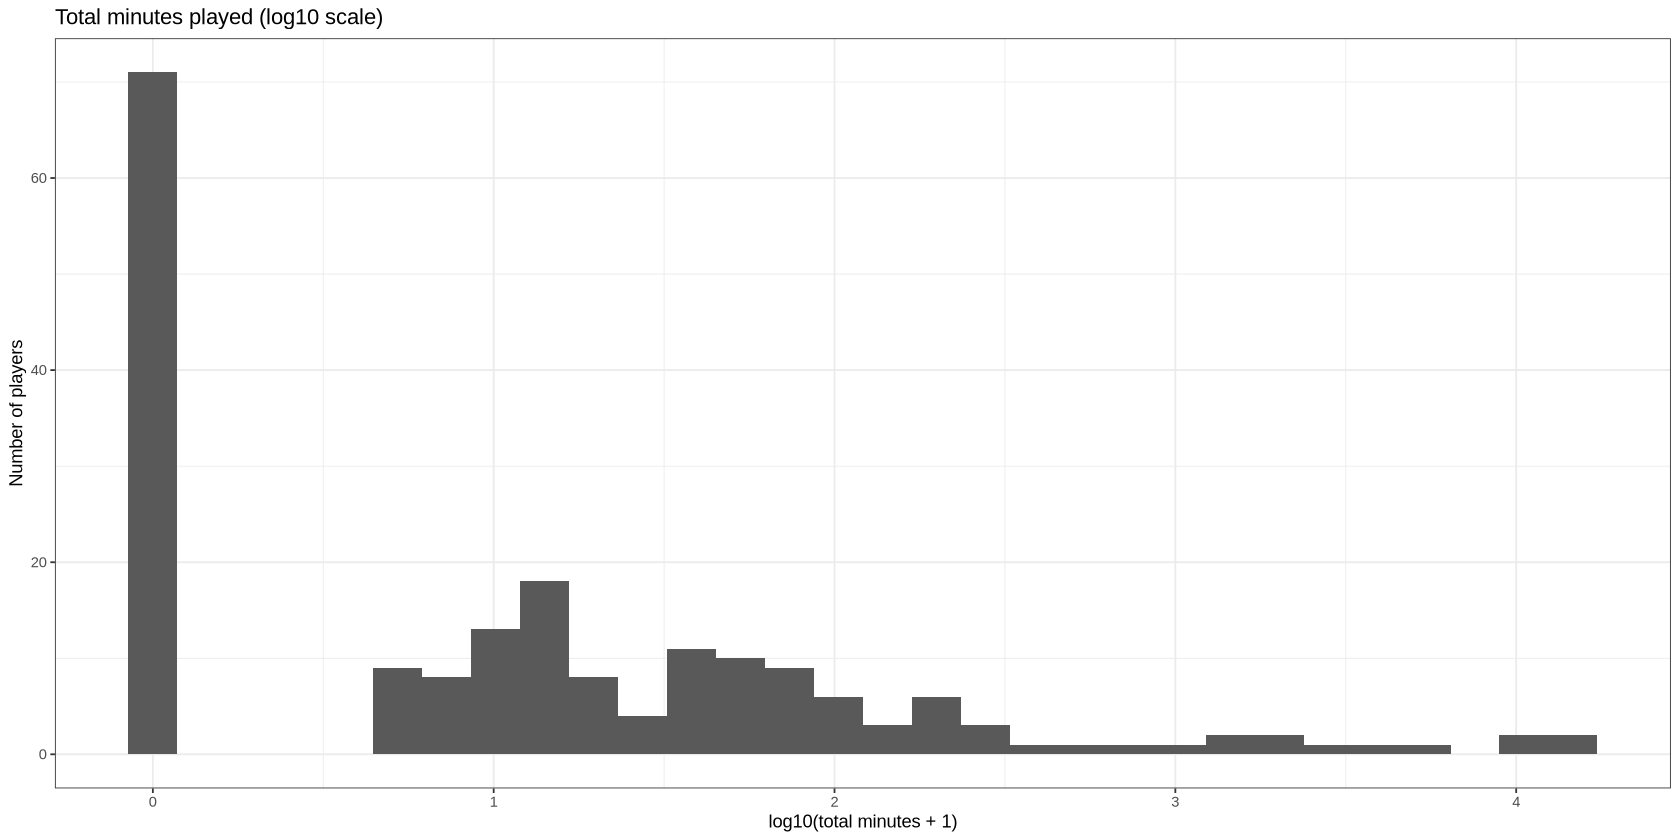

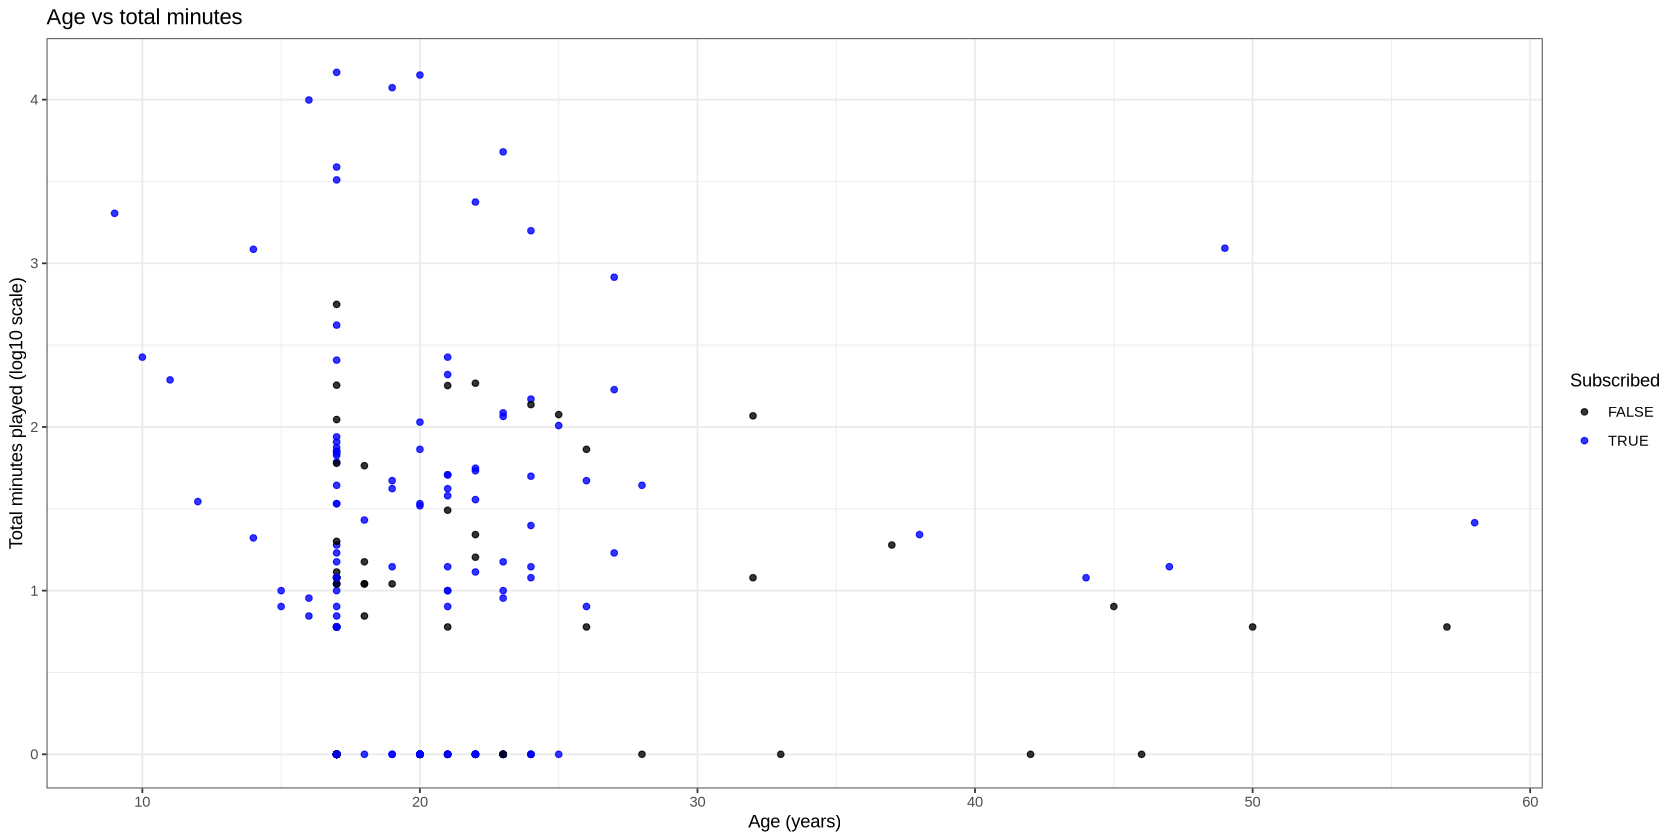

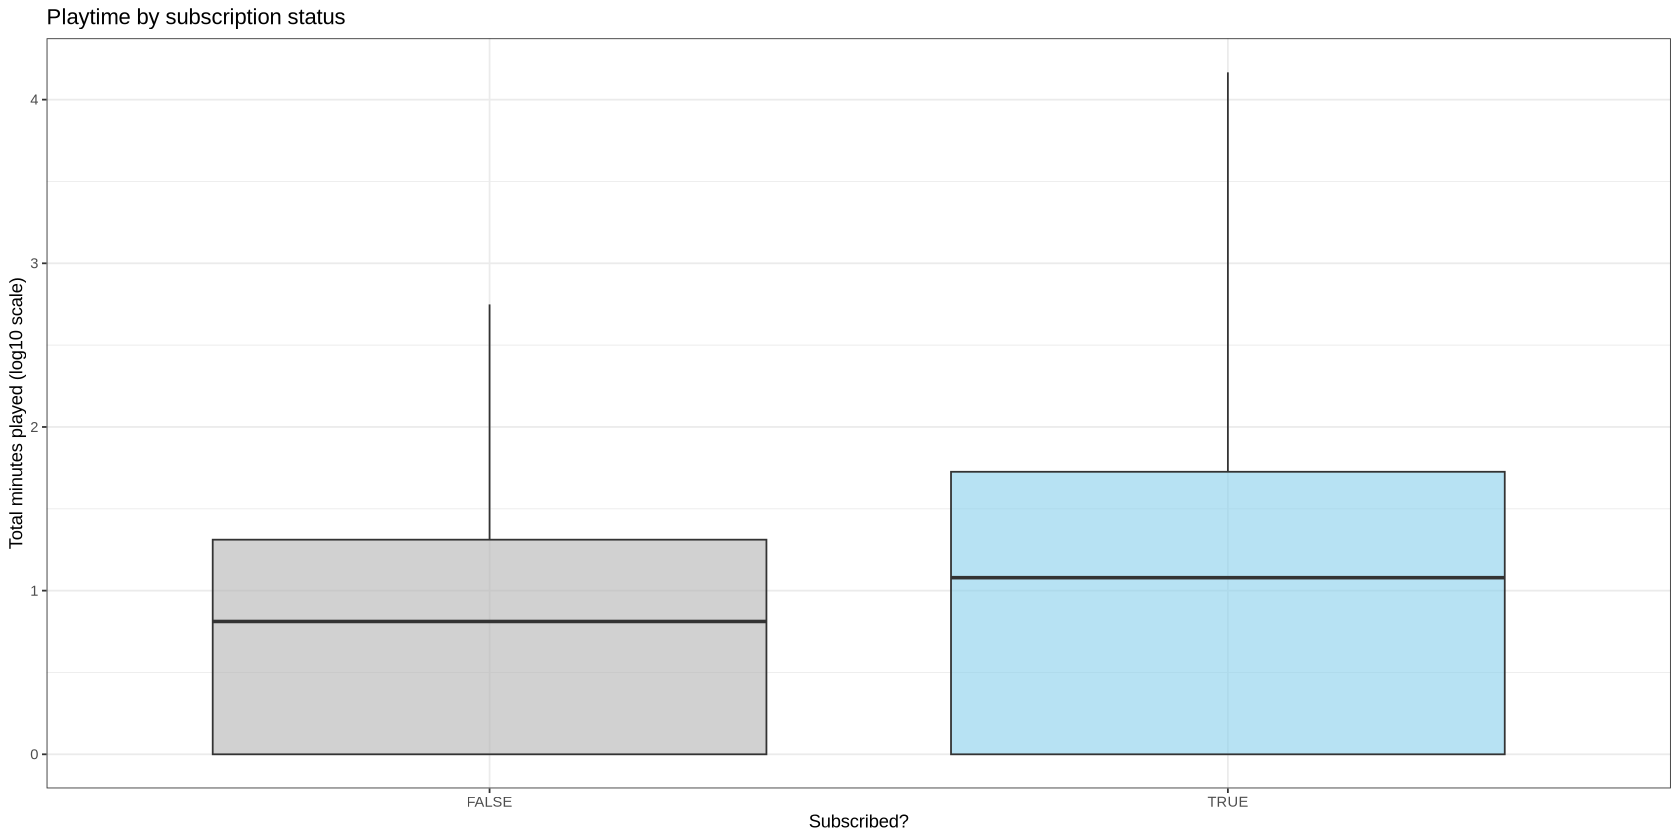

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


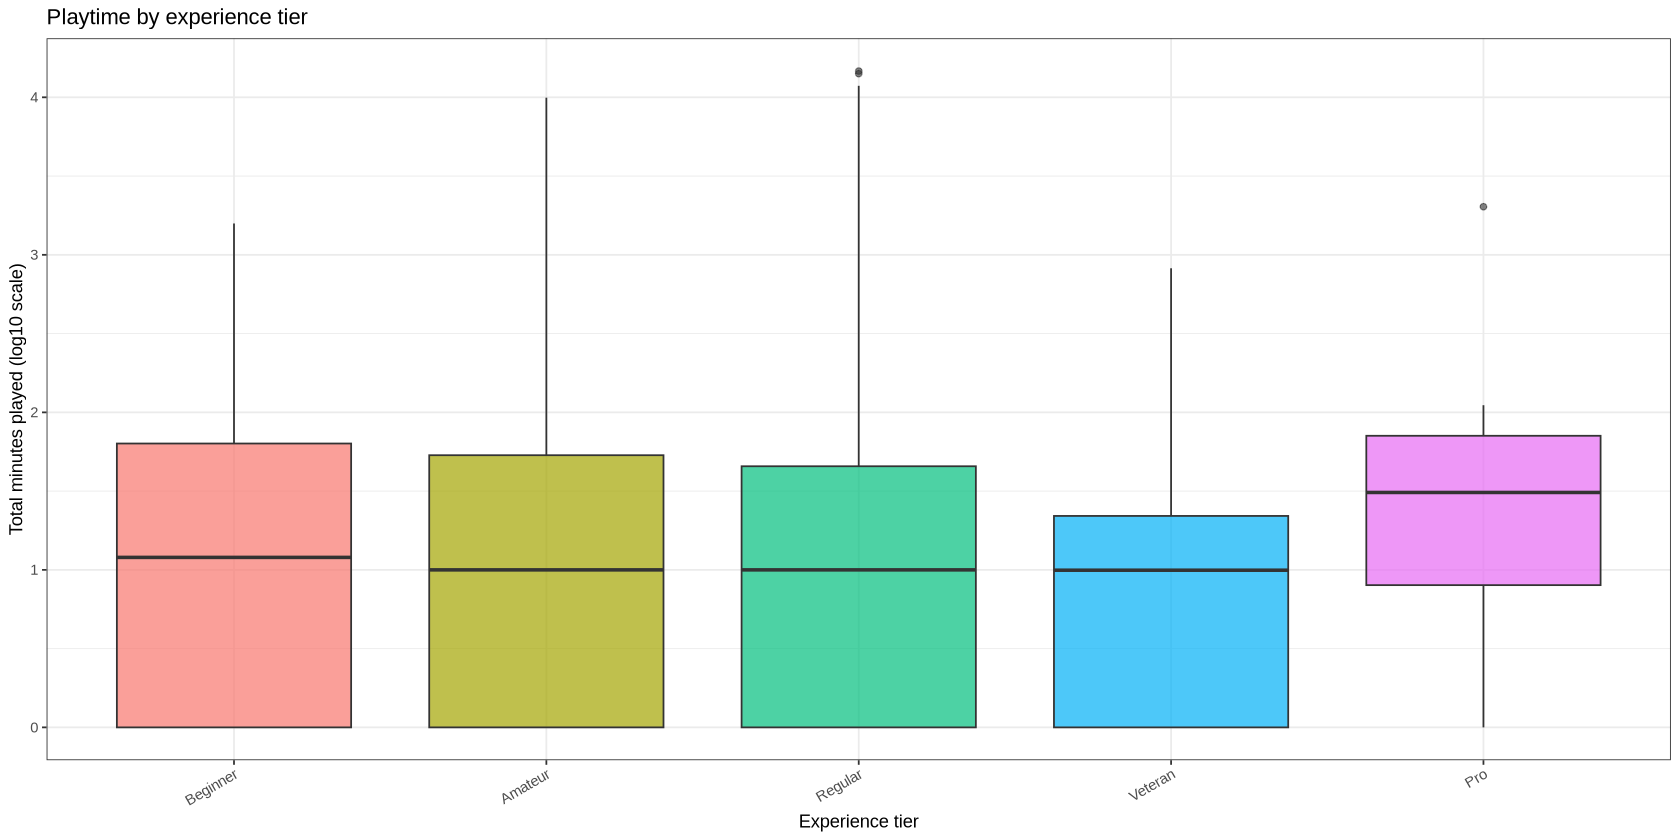

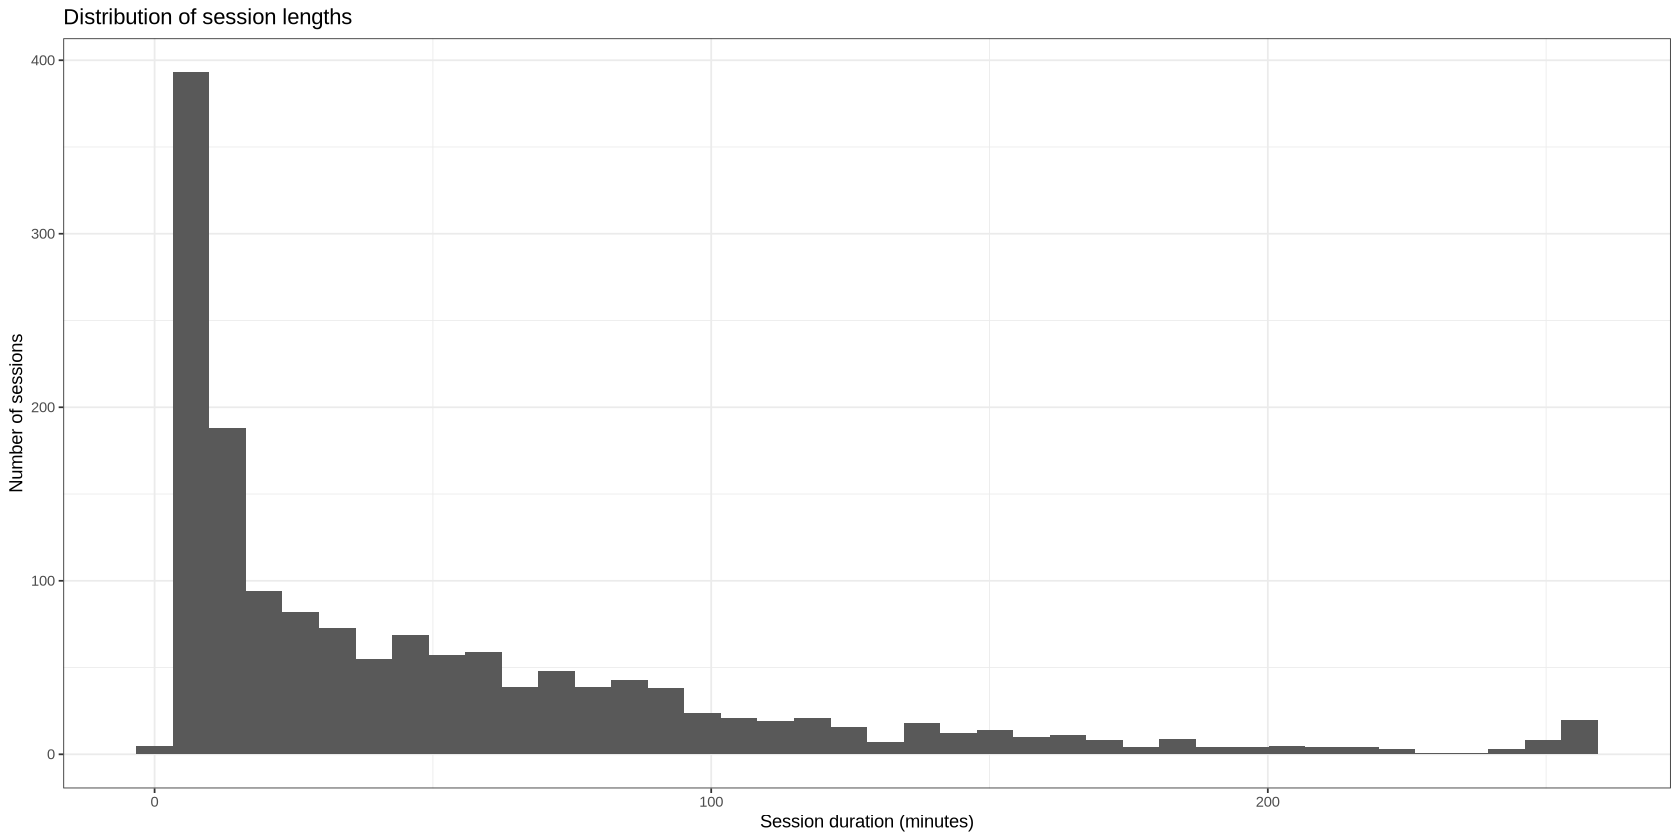

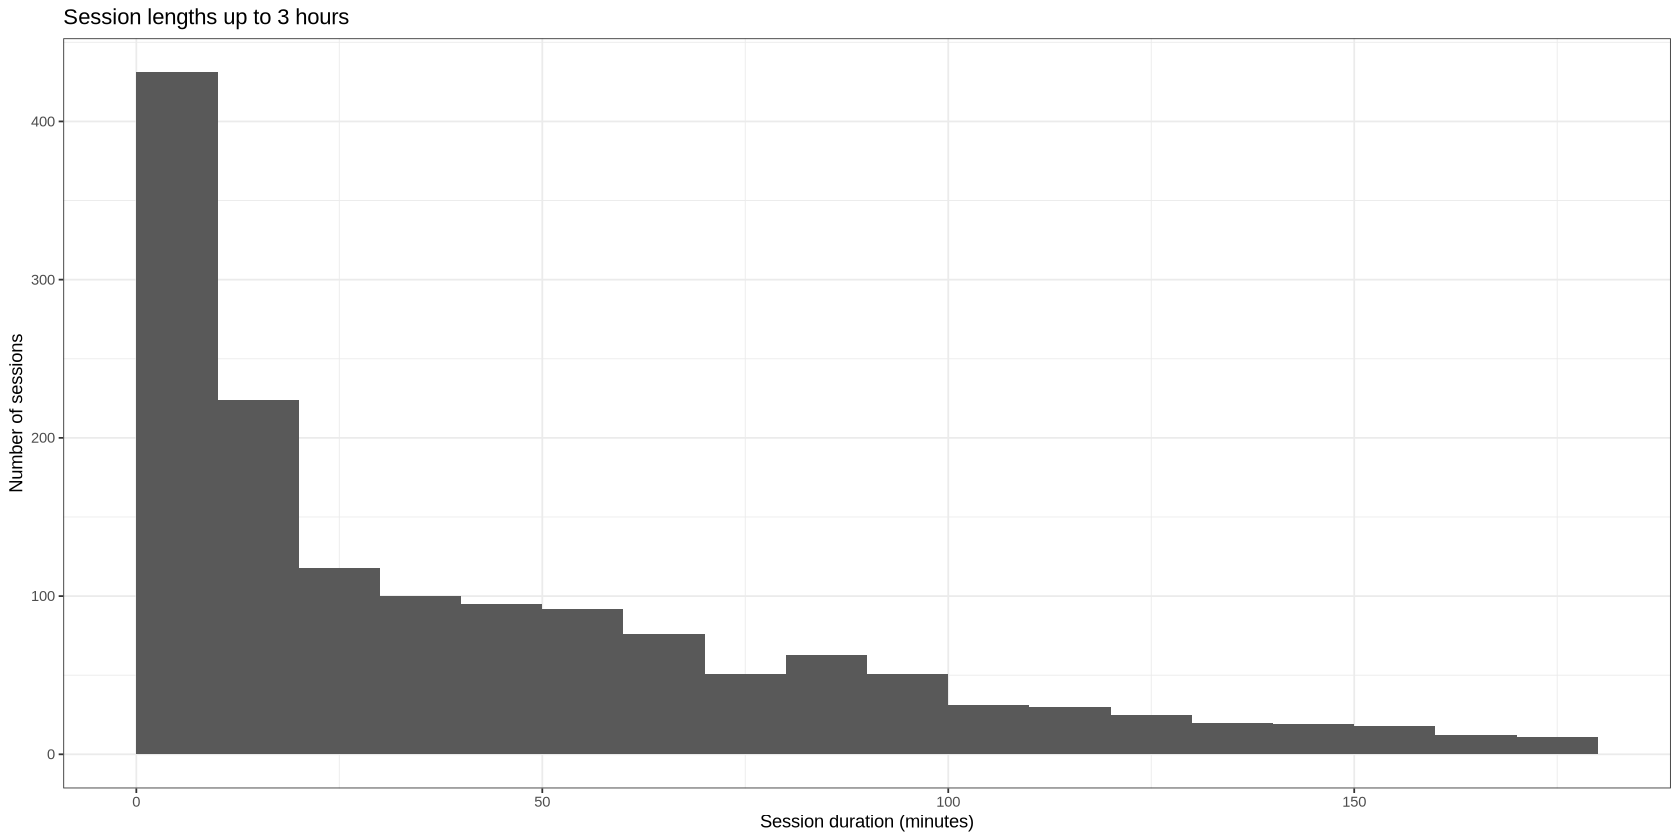

In [14]:
# 1. How are player ages distributed? 
# Gives a feel for who is actually on the server.

dat |>
  ggplot(aes(x = age)) +
  geom_histogram(binwidth = 2, boundary = 0, closed = "left") +
  labs(
    x = "Age (years)",
    y = "Number of players",
    title = "Distribution of player ages"
  ) +
  theme_bw()


# 2. Raw total minutes (super skewed, but good to see once) 
# Shows just how locked in some players are.

dat |>
  ggplot(aes(x = minutes)) +
  geom_histogram(bins = 40) +
  labs(
    x = "Total minutes played",
    y = "Number of players",
    title = "Total minutes played (raw scale)"
  ) +
  theme_bw()


# 3. Total minutes on a log scale 
# Same thing but easier to read the bulk of players.

dat |>
  ggplot(aes(x = log10(minutes + 1))) +
  geom_histogram(bins = 30) +
  labs(
    x = "log10(total minutes + 1)",
    y = "Number of players",
    title = "Total minutes played (log10 scale)"
  ) +
  theme_bw()


# 4. Playtime vs age, coloured by subscription 

dat |>
  ggplot(aes(x = age,
             y = log10(minutes + 1),
             colour = subscribe)) +
  geom_point(alpha = 0.8) +
  scale_colour_manual(
    values = c("FALSE" = "black", "TRUE" = "blue"),
    name = "Subscribed"
  ) +
  labs(
    x = "Age (years)",
    y = "Total minutes played (log10 scale)",
    title = "Age vs total minutes"
  ) +
  theme_bw()


# 5. Do subscribers actually play more? hint: yes lol
# Boxplot of playtime split by subscription status.

dat |>
  ggplot(aes(x = subscribe,
             y = log10(minutes + 1),
             fill = subscribe)) +
  geom_boxplot(alpha = 0.6, outlier.alpha = 0.6) +
  scale_fill_manual(values = c("FALSE" = "grey70", "TRUE" = "skyblue")) +
  labs(
    x = "Subscribed?",
    y = "Total minutes played (log10 scale)",
    title = "Playtime by subscription status"
  ) +
  theme_bw() +
  theme(legend.position = "none")


# 6. Playtime by experience tier 

dat |>
  ggplot(aes(x = experience,
             y = log10(minutes + 1),
             fill = experience)) +
  geom_boxplot(alpha = 0.7, outlier.alpha = 0.6) +
  labs(
    x = "Experience tier",
    y = "Total minutes played (log10 scale)",
    title = "Playtime by experience tier"
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 30, hjust = 1),
        legend.position = "none")


# 7. What do individual sessions look like? 
# Distribution of single-session lengths in minutes.

sessions |>
  ggplot(aes(x = duration_min)) +
  geom_histogram(bins = 40) +
  labs(
    x = "Session duration (minutes)",
    y = "Number of sessions",
    title = "Distribution of session lengths"
  ) +
  theme_bw()


# 8. Zoomed-in view of “normal” sessions 
# Cuts off extreme marathons so we can see the typical range better.

sessions |>
  filter(duration_min <= 180) |>  # keep sessions up to 3 hours
  ggplot(aes(x = duration_min)) +
  geom_histogram(binwidth = 10, boundary = 0) +
  labs(
    x = "Session duration (minutes)",
    y = "Number of sessions",
    title = "Session lengths up to 3 hours"
  ) +
  theme_bw()


## Gitlink

https://github.com/Aki175/Project-Final-Report